In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    cal_img = mpimg.imread(fname)
    gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(cal_img, (nx,ny), corners, ret)
#         plt.imshow(img)

#Get the calibration matrix stuff
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Use the calibration matrix stuff to undistort an image
dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
plt.imshow(dst)
# print(fname)


In [2]:
def undistort(img):
    # variables come from previously run code
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

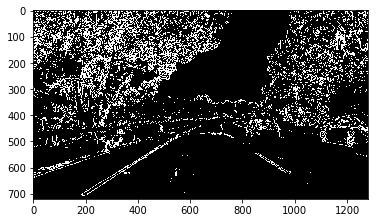

In [3]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
def binary_pipeline(img, s_thresh=(140, 200), sx_thresh=(20,100)): #s_thresh=(185, 215), sx_thresh=(20,130)): #s_thresh=(140, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the binary images
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
img = mpimg.imread('test_images/test5.jpg') ### 
dst = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_pipeline(dst)
# cv2.fillPoly(binary_img, np.int_([[200, 720], [585,460], [690, 460],[1120, 720]]), 255)
# plt.imshow(binary_img, cmap = 'gray')
# line_img = np.zeros_like(binary_img)
# cv2.line(line_img, (144, 720), (544,466), 105, 3)
# cv2.line(line_img, (194, 720), (594,466), 105, 3)
# cv2.line(line_img, (203, 720), (585,460), 105, 3)
# cv2.line(line_img, (695, 460), (1127, 720), 105, 3)
# plt.imshow(line_img)
# combo = line_img
# combo = cv2.addWeighted(binary_img, 155, line_img, 2, 0)
plt.imshow(binary_img, cmap = 'gray')


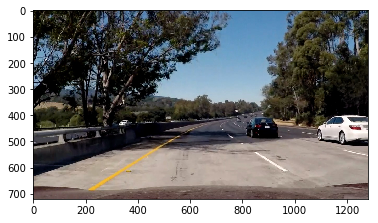

In [4]:
plt.imshow(img)

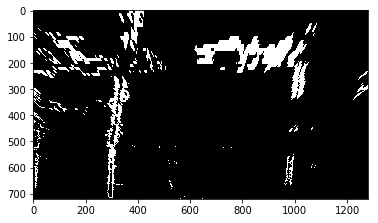

In [5]:
# Apply a perspective transform to rectify binary image ("birds-eye view").
def perspective_transform(binary_img, reverse):
    # img = cv2.imread('test_images/test1.jpg')
    # undist_img_test = cv2.undistort(img, mtx, dist, None, mtx)
    # cv2.line(undist_img_test, (185,720),(515,500),(255,0,0),2)
    # cv2.line(undist_img_test, (1120,720),(770,500),(255,0,0),2)
    # plt.imshow(undist_img_test)
    src = np.float32([[580,460], [203, 720] , [1120, 720], [705, 460]])

#     src = np.float32([[144, 720], [544,466], [740, 466], [1140, 720]])
    dst = np.float32([[320, 0], [320, 720], [960, 720],  [960, 0]])
#     M = cv2.getPerspectiveTransform(src, dst)
    if (reverse==1):
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (binary_img.shape[1], binary_img.shape[0])
#     print(binary_img.shape)
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_LINEAR)
    #     plt.imshow(warped, cmap = 'gray')
    return warped

warped = perspective_transform(binary_img, 0)

plt.imshow(warped, cmap = 'gray')

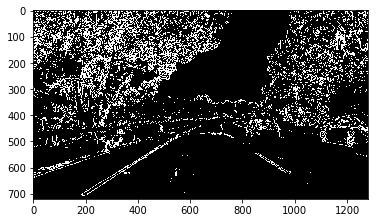

In [6]:
plt.imshow(binary_img, cmap = 'gray')

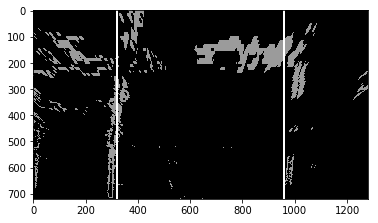

In [7]:
line_check = np.zeros_like(warped)
cv2.line(warped, (320, 720), (320, 0), 255, 5)
cv2.line(warped, (960, 720), (960, 0), 255, 5)
combo_check = cv2.addWeighted(warped, 155, line_check, 2, 0)
plt.imshow(combo_check, cmap='gray')

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

left_line = Line()
right_line = Line()

In [9]:
print(left_line.current_fit)

[array([False], dtype=bool)]


In [10]:
# Detect lane pixels and fit to find the lane boundary
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # start with left side
#         print(good_left_inds.size)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if (left_fit[0] != 0) & (left_fit[1] != 0) & (left_fit[2] != 0):
        left_line.current_fit = left_fit
        left_line.detected = True
    else:
        left_line.detected = False
    if (right_fit[0] != 0) & (right_fit[1] != 0) & (right_fit[2] != 0):
        right_line.current_fit = right_fit
        right_line.detected = True
    else:
        right_line.detected = False

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_line.detected = False
        right_line.detected = False

    ## Visualization ##
    # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]
    new_img = np.zeros_like(out_img)
#     new_img[np.int_(ploty), np.int_(left_fitx)] = [255,0,0]
#     new_img[np.int_(ploty), np.int_(right_fitx)] = [0,0,255]
    new_img[lefty, leftx] = [255,0,0]
    new_img[righty, rightx] = [0,0,255]
    
    #MESH
    grid = np.mgrid[0:720,0:1280]
    gridx = grid[0]
    gridy = grid[1]
    lane_inds = (gridy >= (left_fit[0]*gridx**2 + left_fit[1]*gridx + 
    left_fit[2])) & (gridy < (right_fit[0]*gridx**2 + right_fit[1]*gridx
    + right_fit[2]))
    lane_marked = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3), dtype = np.uint8)
    lane_marked[lane_inds] = (0,255,0)
    
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    out_img = new_img + lane_marked
#     return new_img
    return out_img


# out_img = fit_polynomial(warped)

# plt.imshow(out_img)

In [11]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if (left_fit[0] != 0) & (left_fit[1] != 0) & (left_fit[2] != 0):
        left_line.current_fit = left_fit
        left_line.detected = True
    else:
        left_line.detected = False
    if (right_fit[0] != 0) & (right_fit[1] != 0) & (right_fit[2] != 0):
        right_line.current_fit = right_fit
        right_line.detected = True
    else:
        right_line.detected = False
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = np.poly1d(left_fit)(ploty)
    right_fitx = np.poly1d(right_fit)(ploty)
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 40

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Bring in previous fit values:
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = (nonzerox >= (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] + margin))
    right_lane_inds = (nonzerox >= (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     ploty = np.int_(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]))
    new_img = np.zeros_like(out_img)
#     new_img[ploty, np.int_(left_fitx)] = [255, 0, 0]
#     new_img[ploty, np.int_(right_fitx)] = [0, 0, 255]
    new_img[lefty, leftx] = [255, 0 ,0]
    new_img[righty, rightx] = [0,0,255]
    
    ##MESH
#     objp = np.zeros((6*9,2), np.float32)
    grid = np.mgrid[0:720,0:1280]
    gridx = grid[0]
    gridy = grid[1]
#     lane_inds = (gridy >= (left_fitx[0]*gridx**2 + left_fitx[1]*gridx + 
#     left_fitx[2])) & (gridy < (right_fitx[0]*gridx**2 + right_fitx[1]*gridx
#     + right_fitx[2]))
    left_fit_new = left_line.current_fit
    right_fit_new = right_line.current_fit
    lane_inds = (gridy >= (left_fit_new[0]*gridx**2 + left_fit_new[1]*gridx + 
    left_fit_new[2])) & (gridy < (right_fit_new[0]*gridx**2 + right_fit_new[1]*gridx
    + right_fit_new[2]))
    lane_marked = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3), dtype = np.uint8)
    lane_marked[lane_inds] = (0,255,0)
    
#     plt.imshow(new_img)
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
#     result = new_img
    result = lane_marked + new_img
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
# img = cv2.imread('test_images/test4.jpg')
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# binary_img = binary_pipeline(dst)
# binary_warped = perspective_transform(binary_img, 0)
# result = search_around_poly(binary_warped)

# # View your output
# plt.imshow(result)

In [12]:
def curvature_and_position(img):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 719
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    left_curverad = (1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(1.5) / (np.absolute(2*left_fit[0]))
    right_curverad = (1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(1.5) / (np.absolute(2*right_fit[0]))
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
 
    curv = np.mean((left_curverad, right_curverad))
    
    # Find the position of the car relative to the lane center
    # Find the center of the image
    center = img.shape[1]/2 * xm_per_pix
    # Find the position of the lane lines at the bottom of the image
    left_lane_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])*xm_per_pix
    right_lane_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])*xm_per_pix
    pos = (right_lane_pos + left_lane_pos)/2 - center

    right_line.line_base_pos = pos
    left_line.line_base_pos = pos

    return curv, pos

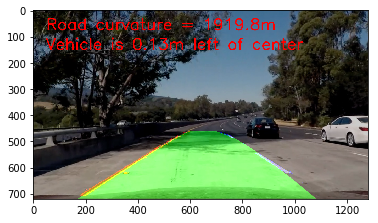

In [28]:

img = mpimg.imread('test_images/test5.jpg')
dst = undistort(img)
# - Use color transforms, gradients, etc., to create a thresholded binary image.
binary_img = binary_pipeline(dst)
# - Apply a perspective transform to rectify binary image ("birds-eye view").
warped = perspective_transform(binary_img, 0)
# - Detect lane pixels and fit to find the lane boundary.
if (left_line.detected == False) | (right_line.detected == False):
    out_img = fit_polynomial(warped)
else:
    out_img = search_around_poly(warped)
# - Determine the curvature of the lane and vehicle position with respect to center.
if (left_line.detected) & (right_line.detected):
    curv, pos = curvature_and_position(out_img)
else:
    curv = 0
    pos = 0
# - Warp the detected lane boundaries back onto the original image.
rewarped = perspective_transform(out_img, 1)
# Overlay it onto the main image
combo = cv2.addWeighted(rewarped, 0.5, dst, 0.8, 0)
# plt.imshow(combo)
# Print the curvature and position on the image
# - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
cv2.putText(combo, 'Road curvature = %.1fm' % (curv), (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
if pos>0:
    cv2.putText(combo, 'Vehicle is %.2fm right of center' % (pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
else:
    cv2.putText(combo, 'Vehicle is %.2fm left of center' % (-1*pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
plt.imshow(combo)

In [14]:
def process_image(image):

    # - Apply a distortion correction to raw images.
    dst = undistort(image)
    
    # - Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_img = binary_pipeline(dst)
    
    # - Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(binary_img, 0)
    
    # - Detect lane pixels and fit to find the lane boundary.
    if (left_line.detected == False) | (right_line.detected == False):
        out_img = fit_polynomial(warped)
    else:
        out_img = search_around_poly(warped)

    # - Determine the curvature of the lane and vehicle position with respect to center.
    curv, pos = curvature_and_position(out_img)

    # - Warp the detected lane boundaries back onto the original image.
    rewarped = perspective_transform(out_img, 1)
    
    # - Overlay it onto the main image
    combo = cv2.addWeighted(rewarped, 0.5, dst, 0.8, 0)

    # - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    cv2.putText(combo, 'Road curvature = %.1fm' % (curv), (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
    if pos>0:
        cv2.putText(combo, 'Vehicle is %.2fm right of center' % (pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
    else:
        cv2.putText(combo, 'Vehicle is %.2fm left of center' % (-1*pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    return combo

In [24]:
left_line.detected = False
right_line.detected = False
# print(right_line.detected)

# # lane_marked = np.zeros_like(img)
# lane_marked = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype = np.uint8)
# lane_marked[lane_inds] = (125,125,0)
# # plt.imshow(lane_marked)
# rw = perspective_transform(lane_marked, 1)
# plt.imshow(rw)
# stack = cv2.addWeighted(dst, 0.8, rw, 1, 0)
# plt.imshow(stack)
# plt.imshow(img)
# print(new_line.current_fit[0]*8)

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
left_line.detected = False
right_line.detected = False
white_output = 'project_video_output.mp4'
# white_output = 'challenge_video_output2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("challenge_video.mp4").subclip(10,14)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output2.mp4
[MoviePy] Writing video challenge_video_output2.mp4



100%|██████████| 120/120 [00:26<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output2.mp4 

CPU times: user 15.2 s, sys: 3.82 s, total: 19 s
Wall time: 29.4 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))